In [1]:
from google.colab import drive
import sys
import os
import random
import numpy as np
import cv2

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

In [3]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
#import tensorflow_datasets as tfds
import numpy as np

In [4]:
import os
import cv2
#DataFolders
data_folder = "/content/drive/My Drive/Kaggle_AD_Dataset/AD_Data_No_Aug/test"

data_mild = data_folder + "/MildDemented/"
data_mod = data_folder + "/ModerateDemented/"
data_non = data_folder + "/NonDemented/"
data_very = data_folder + "/VeryMildDemented/"

print('Number of MildDemented:', len(os.listdir(data_mild)))
print('Number of ModerateDemented:', len(os.listdir(data_mod)))
print('Number of NonDemented:', len(os.listdir(data_non)))
print('Number of VeryMildDemented:', len(os.listdir(data_very)))

Number of MildDemented: 179
Number of ModerateDemented: 12
Number of NonDemented: 640
Number of VeryMildDemented: 448


In [5]:
RESIZE_TO = 224

x, y = [], []
for path in [f for f in os.listdir(data_mild) if f[-4:] == ".jpg"]:
    x.append(cv2.resize(cv2.imread(data_mild + path), (RESIZE_TO, RESIZE_TO)))
    y.append("mild")
for path in [f for f in os.listdir(data_mod) if f[-4:] == ".jpg"]:
    x.append(cv2.resize(cv2.imread(data_mod + path), (RESIZE_TO, RESIZE_TO)))
    y.append("mod")
for path in [f for f in os.listdir(data_non) if f[-4:] == ".jpg"]:
    x.append(cv2.resize(cv2.imread(data_non + path), (RESIZE_TO, RESIZE_TO)))
    y.append("non")
for path in [f for f in os.listdir(data_very) if f[-4:] == ".jpg"]:
    x.append(cv2.resize(cv2.imread(data_very + path), (RESIZE_TO, RESIZE_TO)))
    y.append("very")

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["mild", "mod", "non", "very"])
y_test = le.transform(y)

#Load ResNet Model

In [7]:
x_test, y_test = np.array(x), np.array(y_test)
x_test = tf.keras.applications.resnet.preprocess_input(x_test, data_format = None)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

BATCH_SIZE = 32
test_dataset = test_dataset.batch(BATCH_SIZE)

In [8]:
# Add the pretrained layers
pretrained_model = keras.applications.ResNet50(include_top=False, weights='imagenet')

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add Dropout 
drop = keras.layers.Dropout(0.1)
dropout = drop(average_pooling)

# Add the output layer
output = keras.layers.Dense(4, activation='softmax')(dropout)

# Get the model
model = keras.Model(inputs=pretrained_model.input, outputs=output)

#model.summary()

94781440/94765736 [==============================] - 1s 0us/step


In [9]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Load the saved model
abspath_curr = '/content/drive/My Drive/Models'
model.load_weights(filepath=abspath_curr + '/shift_ResNet50_model.h5')

In [11]:
loss, accuracy = model.evaluate(test_dataset)

40/40 [==============================] - 203s 5s/step - loss: 1.1548 - accuracy: 0.7482


In [12]:
def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 
    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels
    return labels

In [13]:
def get_images_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[0], tfdataset)) # Get labels 
    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels
    return labels

In [14]:
x_test = get_images_from_tfdataset(test_dataset, batched=False)
y_test = get_labels_from_tfdataset(test_dataset, batched = False)

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
class_names_tr = ["mild", "mod", "non", "very"]

y_pred_resnet = model.predict(x_test)
pred_resnet = np.argmax(y_pred_resnet, axis=1)
print(classification_report(y_test, pred_resnet, target_names=class_names_tr))
print("Accuracy : ", accuracy_score(y_test, pred_resnet) * 100)
print("\n")

              precision    recall  f1-score   support

        mild       0.82      0.37      0.51       179
         mod       1.00      1.00      1.00        12
         non       0.77      0.86      0.81       640
        very       0.70      0.73      0.72       448

    accuracy                           0.75      1279
   macro avg       0.82      0.74      0.76      1279
weighted avg       0.75      0.75      0.74      1279

Accuracy :  74.8240813135262




#Load VGG16 Model

In [16]:
x_test, y_test = np.array(x), np.array(y_test)
x_test = tf.keras.applications.vgg16.preprocess_input(x_test, data_format = None)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

BATCH_SIZE = 32
test_dataset = test_dataset.batch(BATCH_SIZE)

In [17]:
#Loading VGG16 Model

# Add the pretrained layers
pretrained_model = keras.applications.VGG16(include_top=False, weights='imagenet')

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add Dropout
drop = keras.layers.Dropout(0.1)
dropout = drop(average_pooling)

# Add the output layer
output = keras.layers.Dense(4, activation='softmax')(dropout)

# Get the model
model = keras.Model(inputs=pretrained_model.input, outputs=output)

#model.summary()

58900480/58889256 [==============================] - 0s 0us/step


In [18]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# Load the saved model
model.load_weights(filepath=abspath_curr + '/shift_VGG16_model.h5')

In [20]:
x_test = get_images_from_tfdataset(test_dataset, batched=False)
y_test = get_labels_from_tfdataset(test_dataset, batched = False)

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
class_names_tr = ["mild", "mod", "non", "very"]

y_pred_vgg16 = model.predict(x_test)
pred_vgg16 = np.argmax(y_pred_vgg16, axis=1)
print(classification_report(y_test, pred_vgg16, target_names=class_names_tr))
print("Accuracy : ", accuracy_score(y_test, pred_vgg16) * 100)
print("\n")

              precision    recall  f1-score   support

        mild       0.58      0.37      0.45       179
         mod       1.00      0.17      0.29        12
         non       0.80      0.78      0.79       640
        very       0.58      0.70      0.64       448

    accuracy                           0.69      1279
   macro avg       0.74      0.50      0.54      1279
weighted avg       0.70      0.69      0.69      1279

Accuracy :  69.03831118060985




#Load Xception model

In [22]:
RESIZE_TO = 299

x, y = [], []
for path in [f for f in os.listdir(data_mild) if f[-4:] == ".jpg"]:
    x.append(cv2.resize(cv2.imread(data_mild + path), (RESIZE_TO, RESIZE_TO)))
    y.append("mild")
for path in [f for f in os.listdir(data_mod) if f[-4:] == ".jpg"]:
    x.append(cv2.resize(cv2.imread(data_mod + path), (RESIZE_TO, RESIZE_TO)))
    y.append("mod")
for path in [f for f in os.listdir(data_non) if f[-4:] == ".jpg"]:
    x.append(cv2.resize(cv2.imread(data_non + path), (RESIZE_TO, RESIZE_TO)))
    y.append("non")
for path in [f for f in os.listdir(data_very) if f[-4:] == ".jpg"]:
    x.append(cv2.resize(cv2.imread(data_very + path), (RESIZE_TO, RESIZE_TO)))
    y.append("very")

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["mild", "mod", "non", "very"])
y_test = le.transform(y)

In [24]:
x_test, y_test = np.array(x), np.array(y_test)
x_test = tf.keras.applications.xception.preprocess_input(x_test, data_format = None)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

BATCH_SIZE = 32
test_dataset = test_dataset.batch(BATCH_SIZE)

In [25]:
#Loading Xception Model

# Add the pretrained layers
pretrained_model = keras.applications.Xception(include_top=False, weights='imagenet')

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add Dropout 
drop = keras.layers.Dropout(0.1)
dropout = drop(average_pooling)

# Add the output layer
output = keras.layers.Dense(4, activation='softmax')(dropout)

# Get the model
model = keras.Model(inputs=pretrained_model.input, outputs=output)

#model.summary()

83697664/83683744 [==============================] - 1s 0us/step


In [26]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
# Load the saved model
model.load_weights(filepath=abspath_curr + '/shift_Xception_model.h5')

In [28]:
x_test = get_images_from_tfdataset(test_dataset, batched=False)
y_test = get_labels_from_tfdataset(test_dataset, batched = False)

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
class_names_tr = ["mild", "mod", "non", "very"]

y_pred_xcept = model.predict(x_test)
pred_xcept = np.argmax(y_pred_xcept, axis=1)
print(classification_report(y_test, pred_xcept, target_names=class_names_tr))
print("Accuracy : ", accuracy_score(y_test, pred_xcept) * 100)
print("\n")

              precision    recall  f1-score   support

        mild       0.80      0.50      0.62       179
         mod       0.56      0.83      0.67        12
         non       0.84      0.69      0.76       640
        very       0.61      0.84      0.71       448

    accuracy                           0.72      1279
   macro avg       0.70      0.72      0.69      1279
weighted avg       0.75      0.72      0.72      1279

Accuracy :  72.08756841282252




In [30]:
import pandas as pd
#Combining the models
df1 = pd.DataFrame(y_pred_resnet, columns = ["mild1", "mod1", "non1", "very1"])
df2 = pd.DataFrame(y_pred_vgg16, columns = ["mild2", "mod2", "non2", "very2"])
df3 = pd.DataFrame(y_pred_xcept, columns = ["mild3", "mod3", "non3", "very3"])

df_target = pd.DataFrame(y, columns = ['target'])

df1['mild2'] = df2['mild2']
df1['mod2'] = df2['mod2']
df1['non2'] = df2['non2']
df1['very2'] = df2['very2']

df1['mild3'] = df3['mild3']
df1['mod3'] = df3['mod3']
df1['non3'] = df3['non3']
df1['very3'] = df3['very3']

df1['target'] = df_target['target']

In [31]:
df1

,mild1,mod1,non1,very1,mild2,mod2,non2,very2,mild3,mod3,non3,very3,target
0,6.869561e-01,5.136539e-06,0.311814,0.001224,0.002607,4.616061e-08,0.589123,0.408270,0.999881,3.392238e-05,4.824037e-05,0.000036,mild
1,2.952032e-01,1.046946e-04,0.353254,0.351438,0.450478,5.934722e-07,0.050777,0.498744,0.877252,2.541937e-06,6.271919e-02,0.060026,mild
2,4.538712e-02,2.240127e-05,0.162286,0.792305,0.024907,8.539470e-08,0.089811,0.885282,0.743481,4.092175e-06,1.352151e-01,0.121299,mild
3,9.862058e-01,4.380234e-06,0.000948,0.012842,0.998428,8.421543e-08,0.000562,0.001010,0.996401,3.398987e-08,5.353014e-07,0.003598,mild
4,8.418527e-01,4.924598e-07,0.046375,0.111772,0.647946,5.496316e-06,0.012049,0.339999,0.824395,9.852059e-07,6.257508e-03,0.169346,mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,1.225779e-05,5.469460e-05,0.181109,0.818824,0.059487,4.190398e-06,0.242797,0.697712,0.001214,1.274106e-01,5.462531e-03,0.865913,very
1275,2.331303e-05,1.243776e-06,0.066117,0.933858,0.000153,2.476680e-09,0.037964,0.961883,0.122486,4.676188e-04,1.695602e-03,0.875350,very
1276,1.587982e-07,5.679686e-07,0.000490,0.999509,0.000426,2.677402e-09,0.005519,0.994055,0.000037,3.747479e-06,2.037769e-05,0.999938,very
1277,2.334883e-06,8.847104e-06,0.954896,0.045093,0.000794,1.828156e-08,0.548749,0.450457,0.000407,1.440894e-05,2.023271e-03,0.997556,very


In [32]:
#https://github.com/amir-jafari/Data-Mining/blob/master/9-Random%20Forest/1-Example_Exercise/RF_1.py
# %%%%%%%%%%%%% Random Forest  %%%%%%%%%%%%%%%%%%%%%%%%%%
#%%-----------------------------------------------------------------------
# Importing the required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [33]:
# import Dataset
# read data as panda dataframe
data = df1

# printing the dataswet rows and columns
print("Dataset No. of Rows: ", data.shape[0])
print("Dataset No. of Columns: ", data.shape[1])

# printing the dataset obseravtions
print("Dataset first few rows:\n ")
print(data.head(2))

Dataset No. of Rows:  1279
Dataset No. of Columns:  13
Dataset first few rows:
 
      mild1      mod1      non1     very1     mild2          mod2      non2  \
0  0.686956  0.000005  0.311814  0.001224  0.002607  4.616061e-08  0.589123   
1  0.295203  0.000105  0.353254  0.351438  0.450478  5.934722e-07  0.050777   

      very2     mild3      mod3      non3     very3 target  
0  0.408270  0.999881  0.000034  0.000048  0.000036   mild  
1  0.498744  0.877252  0.000003  0.062719  0.060026   mild  


In [34]:
#split the dataset
# separate the predictor and target variable
X = data.values[:, 0:12]
Y = data.values[:, 12]

# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

In [35]:
#perform training with random forest with all columns
# specify random forest classifier
clf = RandomForestClassifier(n_estimators=100)

# perform training
clf.fit(X_train, y_train)

RandomForestClassifier()

In [36]:
# predicton on test using all features
y_pred = clf.predict(X_test)
y_pred_score = clf.predict_proba(X_test)

In [37]:
# calculate metrics gini model

print("\n")
print("Results Using All Features: \n")

print("Classification Report: ")
print(classification_report(y_test,y_pred))
print("\n")

print("Accuracy : ", accuracy_score(y_test, y_pred) * 100)
print("\n")



Results Using All Features: 

Classification Report: 
              precision    recall  f1-score   support

        mild       0.78      0.63      0.70        62
         mod       1.00      0.50      0.67         2
         non       0.83      0.86      0.85       191
        very       0.76      0.81      0.78       129

    accuracy                           0.80       384
   macro avg       0.84      0.70      0.75       384
weighted avg       0.80      0.80      0.80       384



Accuracy :  80.20833333333334




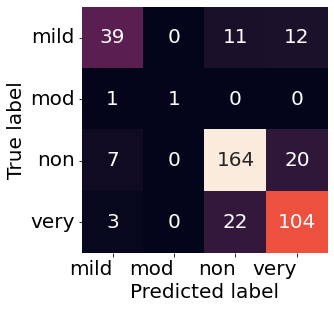

In [38]:
# confusion matrix for gini model
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ["mild", "mod", "non", "very"]


df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names )

plt.figure(figsize=(5,5))

hm = sns.heatmap(df_cm, cbar=False, annot=True, square=True, fmt='d', annot_kws={'size': 20}, yticklabels=df_cm.columns, xticklabels=df_cm.columns)

hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=20)
hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=20)
plt.ylabel('True label',fontsize=20)
plt.xlabel('Predicted label',fontsize=20)
# Show heat map
plt.tight_layout()